# Ungraded Lab: Training a Deep Neural Network with Time Series Data

In this lab, you will build upon the previous exercise and add more dense layers to your network. You will also look at a technique to tune the model's learning rate to make the weights converge faster. This is a useful tip so you can avoid guessing the learning rate before training.

The initial steps will be identical to the previous lab so you can run the next cells until the `Build the Model` section. That's where the discussions begin.

## Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2024-10-03 11:33:34.638750: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-03 11:33:34.646444: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-03 11:33:34.655713: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-03 11:33:34.658334: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-03 11:33:34.665236: I tensorflow/core/platform/cpu_feature_guar

## Utilities

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      label - tag for the line
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish
    
    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according 
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
    
    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """
    
    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level
    
    return noise

## Generate the Synthetic Data

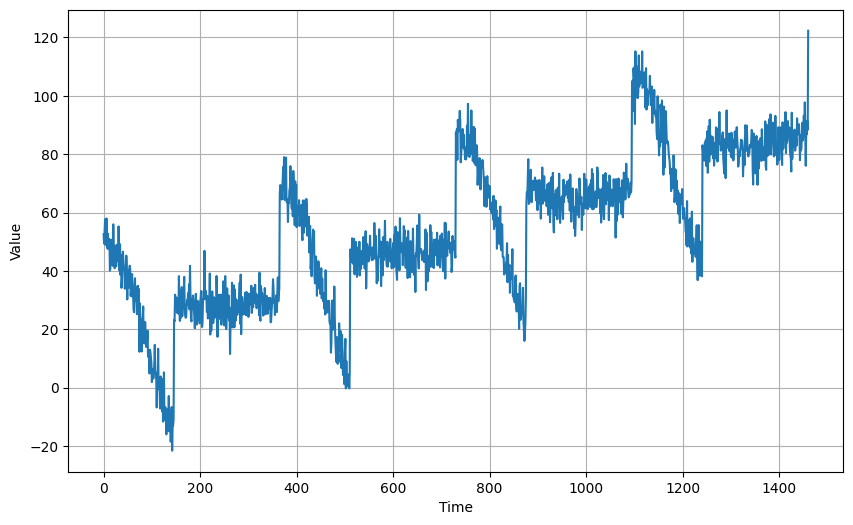

In [3]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

## Split the Dataset

In [4]:
# Define the split time
split_time = 1000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

## Prepare Features and Labels

In [5]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to average
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size)
    
    # Optimize the dataset for training
    dataset = dataset.cache().prefetch(1)
    
    return dataset

In [7]:
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

2024-10-03 11:33:46.776557: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10383 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


## Build the Model

You will use three dense layers in this exercise as shown below. As expected, the number of trainable parameters will increase and the model summary shows that it is more than tenfold of the previous lab.

In [8]:
# Build the model
model_baseline = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size,)),
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

# Print the model summary
model_baseline.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 331 (1.29 KB)

 Trainable params: 331 (1.29 KB)

 Non-trainable params: 0 (0.00 B)

## Train the Model

You will then compile and train the model using the same settings as before. Observe how the loss is decreasing because you will revisit it later in this lab.

In [9]:
# Set the training parameters
model_baseline.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

In [10]:
# Train the model
model_baseline.fit(dataset,epochs=100)

Epoch 1/100


I0000 00:00:1727980435.749838 2238277 service.cc:146] XLA service 0x77a864019630 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727980435.749863 2238277 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-10-03 11:33:55.758456: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-03 11:33:55.786120: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-10-03 11:33:55.804035: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:762] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility

      1/Unknown 1s 580ms/step - loss: 4739.0386

I0000 00:00:1727980436.086387 2238277 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1608.8937
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 70.1431
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 62.2501
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 59.7997
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 58.6928
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - loss: 58.0175
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step - loss: 57.4424
Epoch 8/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 31.7656

2024-10-03 11:33:56.378799: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-03 11:33:56.378835: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-10-03 11:33:56.378846: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:33:56.378858: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
/home/codingfreak/anaconda3/envs/tf-gpu/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - loss: 56.9315
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 56.4644
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 56.0237
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 55.6309
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step - loss: 55.2583
Epoch 13/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - loss: 54.9071
Epoch 14/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 54.5614
Epoch 15/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 54.2639
Epoch 16/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 53.9580
Epoch 17/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31.2895

2024-10-03 11:33:56.599948: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-10-03 11:33:56.599955: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:33:56.599959: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:33:56.614427: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:33:56.614435: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:33:56.628883: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:33:56.628889: I tensorflow/core/f

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 53.6532
Epoch 18/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 53.3893
Epoch 19/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 53.1144
Epoch 20/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 52.8424
Epoch 21/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 52.5929
Epoch 22/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - loss: 52.3539
Epoch 23/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 52.1027
Epoch 24/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 51.8681
Epoch 25/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 51.6448
Epoch 26/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 51.4270
Epoch 27/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 51.2329
Epoch 28/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 51.0218
Epoch 29/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - loss: 50.8286
Epoch 30/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 30.5982

2024-10-03 11:33:56.809182: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:33:56.809211: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:33:56.823378: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:33:56.823402: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:33:56.837985: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:33:56.838015: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:33:56.855332: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv ite

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - loss: 50.6391
Epoch 31/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - loss: 50.4596
Epoch 32/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step - loss: 50.2678
Epoch 33/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 50.1119
Epoch 34/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 49.9289
Epoch 35/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 49.7725
Epoch 36/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 49.6272
Epoch 37/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - loss: 49.4625
Epoch 38/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - loss: 49.3030
Epoch 39/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 30.0236

2024-10-03 11:33:57.015408: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:33:57.050307: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:33:57.050330: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:33:57.073954: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-10-03 11:33:57.073975: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:33:57.073985: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:33:57.090422: I tensorflow/core

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 49.1674
Epoch 40/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 49.0136
Epoch 41/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 48.8891
Epoch 42/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 48.7364
Epoch 43/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 48.6087
Epoch 44/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 48.5102
Epoch 45/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 48.3855
Epoch 46/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 48.2631
Epoch 47/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - loss: 48.1549
Epoch 48/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29.5646

2024-10-03 11:33:57.224286: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:33:57.224354: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:33:57.279533: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:33:57.279578: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:33:57.322948: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:33:57.322966: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:33:57.336337: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv ite

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 48.0316
Epoch 49/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step - loss: 47.9637
Epoch 50/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 47.8405
Epoch 51/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - loss: 47.7316
Epoch 52/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 47.6536
Epoch 53/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 47.5570
Epoch 54/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 47.4864
Epoch 55/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 47.3864
Epoch 56/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 47.2902
Epoch 57/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 47.2265
Epoch 58/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - loss: 47.1166
Epoch 59/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - loss: 47.0544
Epoch 60/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 46.9803
Epoch 61/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 46.8967
Epoch 62/100
 1/31 ━━━━━━━━━━━━━━

2024-10-03 11:33:57.426419: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:33:57.426434: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:33:57.439725: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:33:57.439739: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:33:57.453890: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:33:57.453912: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:33:57.472765: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv ite

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 46.8212
Epoch 63/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 46.7396
Epoch 64/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 46.6929
Epoch 65/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 46.6030
Epoch 66/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step - loss: 46.5249
Epoch 67/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 46.4662
Epoch 68/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 46.4030
Epoch 69/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 46.3274
Epoch 70/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 46.2685
Epoch 71/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 46.1881
Epoch 72/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 46.1362
Epoch 73/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 46.0801
Epoch 74/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step - loss: 45.9905
Epoch 75/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 45.9418
Epoch 76/100
31/31 ━━━━━━━━━━━━━━

2024-10-03 11:33:57.637790: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:33:57.637805: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:33:57.650464: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:33:57.650478: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:33:57.665858: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-10-03 11:33:57.665873: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:33:57.665881: I tensorflow/core/f

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 45.8245
Epoch 78/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 665us/step - loss: 45.7626
Epoch 79/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step - loss: 45.6970
Epoch 80/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - loss: 45.6543
Epoch 81/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step - loss: 45.5916
Epoch 82/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 45.5332
Epoch 83/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 45.4724
Epoch 84/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 45.4380
Epoch 85/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - loss: 45.3697
Epoch 86/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - loss: 45.3097
Epoch 87/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - loss: 45.2368
Epoch 88/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 28.3748

2024-10-03 11:33:57.846526: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:33:57.846553: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:33:57.867936: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:33:57.867969: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:33:57.923317: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:33:57.923343: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:33:57.943447: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv ite

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 45.2069
Epoch 89/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - loss: 45.1667
Epoch 90/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - loss: 45.1092
Epoch 91/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - loss: 45.0562
Epoch 92/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 45.0237
Epoch 93/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 44.9754
Epoch 94/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 28.2607

2024-10-03 11:33:58.049331: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:33:58.049348: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:33:58.066929: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:33:58.066951: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:33:58.094461: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:33:58.094483: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:33:58.126369: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv ite

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - loss: 44.9244
Epoch 95/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step - loss: 44.8883
Epoch 96/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - loss: 44.8345
Epoch 97/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - loss: 44.8084
Epoch 98/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 44.7587
Epoch 99/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - loss: 44.7099
Epoch 100/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step - loss: 44.6732


2024-10-03 11:33:58.257454: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:33:58.257473: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:33:58.270978: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:33:58.270997: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:33:58.294049: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:33:58.294086: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:33:58.316963: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv ite

You can then get some predictions and visualize it as before. Since the network is deeper, the predictions might go slower so you may want to minimize unnecessary computations. 

In the previous lab, you might remember the model generating predictions using the entire `series` data. That resulted in 1,441 points in the `forecast` list then you sliced the 461 points that aligns with the validation set using `forecast = forecast[split_time - window_size:]`. 

You can make this process faster by just generating 461 points right from the start. That way, you don't waste time predicting points that will just be thrown away later. The code below will do just that. It will just get the points needed from the original `series` before calling the `predict()` method. With that, all predictions will align with the validation set already and the for-loop will run for only 461 times instead of 1,441. 

In the next lab, you'll see an even faster way to generate these predictions.

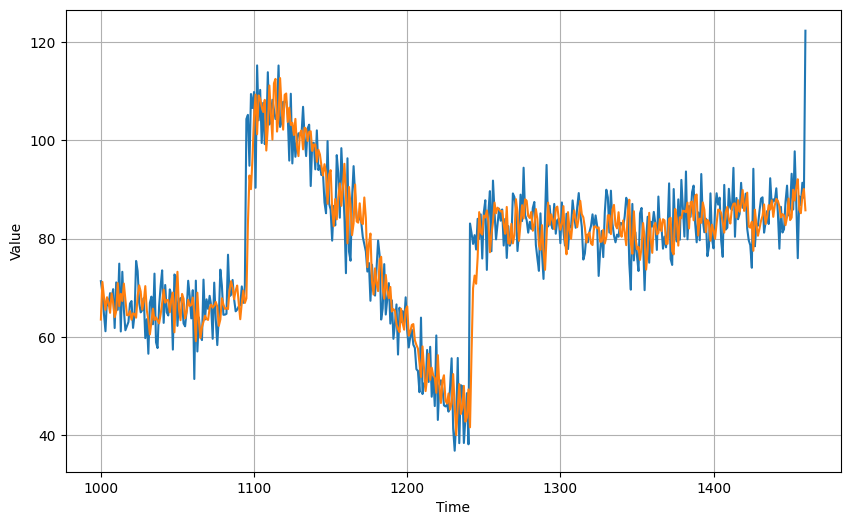

In [11]:
# Initialize a list
forecast = []

# Reduce the original series
forecast_series = series[split_time - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
  forecast.append(model_baseline.predict(forecast_series[time:time + window_size][np.newaxis], verbose=0))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

You can then get the MSE and MAE for reference.

In [13]:
# Compute the metrics
print(tf.keras.metrics.mse(x_valid, results).numpy())
print(tf.keras.metrics.mae(x_valid, results).numpy())

49.910194
5.2951612


## Tune the learning rate

You saw that the training went well with the initial learning rate that you chose (i.e. `1e-6`). However, you're not yet sure if it is the best setting for this particular model. It might seem inconsequential in this simple model but when you have more complex ones, spending some time to tune the learning rate can lead to better training results. You will see how to do that in this section.

First, you will build the same model architecture you just used.

In [14]:
# Build the Model
model_tune = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size,)),
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

Next, you will declare a [learning rate scheduler](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler) callback. This will allow you to dynamically set the learning rate based on the epoch number during training. As shown below, you will pass a lambda function to declare the value of the learning rate. It will start at `1e-8` at epoch 0 and is scaled by `10**(epoch / 20)` as the training goes on.

In [15]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

You will then compile the model. Just to note a subtle difference with the lecture video, you don't have to set the `learning_rate` argument of the optimizer here before compiling. You can just leave the default (i.e. [`0.01` for SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD#args)) and allow the learning rate scheduler to set it dynamically.

In [16]:
# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model_tune.compile(loss="mse", optimizer=optimizer)

You will pass in the `lr_schedule` callback in the `callbacks` parameter of the [`fit()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) method. As you run the training below, you will see the learning rate at a particular epoch denoted by `lr` in the console output. Notice that it is increasing as expected based on the lambda function you used.

In [17]:
# Train the model
history = model_tune.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6337.4741 - learning_rate: 1.0000e-08
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 4345.0498 - learning_rate: 1.1220e-08
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 2562.2537 - learning_rate: 1.2589e-08
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step - loss: 1165.2692 - learning_rate: 1.4125e-08
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - loss: 459.9079 - learning_rate: 1.5849e-08
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 206.3655 - learning_rate: 1.7783e-08
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step - loss: 139.4470 - learning_rate: 1.9953e-08
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 127.5346 - learning_rate: 2.2387e-08
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 126.2796 - learning_rate: 2.5119e-08
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - loss: 125.8630 - learning_rate: 2.8184e-08
Epoch 11/100
31/3

2024-10-03 11:34:41.400773: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:34:41.400811: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:34:41.417973: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:34:41.418003: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:34:41.433769: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:34:41.433790: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:34:41.448941: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv ite

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 121.2692 - learning_rate: 5.0119e-08
Epoch 16/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 120.0636 - learning_rate: 5.6234e-08
Epoch 17/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - loss: 118.8623 - learning_rate: 6.3096e-08
Epoch 18/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 117.6353 - learning_rate: 7.0795e-08
Epoch 19/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 116.2994 - learning_rate: 7.9433e-08
Epoch 20/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 114.8124 - learning_rate: 8.9125e-08
Epoch 21/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - loss: 113.2122 - learning_rate: 1.0000e-07
Epoch 22/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step - loss: 111.5837 - learning_rate: 1.1220e-07
Epoch 23/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 109.7872 - learning_rate: 1.2589e-07
Epoch 24/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step - loss: 107.9615 - learning_rate: 1.4125e-07
Epoch 25/100
31/31 ━━━━━━

2024-10-03 11:34:41.605255: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:34:41.605270: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:34:41.618882: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:34:41.618897: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:34:41.632211: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:34:41.632221: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:34:41.645391: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv ite

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step - loss: 103.9322 - learning_rate: 1.7783e-07
Epoch 27/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 101.8319 - learning_rate: 1.9953e-07
Epoch 28/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step - loss: 99.7628 - learning_rate: 2.2387e-07
Epoch 29/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 97.5709 - learning_rate: 2.5119e-07
Epoch 30/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 95.4457 - learning_rate: 2.8184e-07
Epoch 31/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 93.2495 - learning_rate: 3.1623e-07
Epoch 32/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 91.0027 - learning_rate: 3.5481e-07
Epoch 33/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 52.6494

2024-10-03 11:34:41.814552: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:34:41.814560: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:34:41.828652: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:34:41.828669: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:34:41.841402: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-10-03 11:34:41.841409: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:34:41.841414: I tensorflow/core/f

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 88.8085 - learning_rate: 3.9811e-07
Epoch 34/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - loss: 86.5984 - learning_rate: 4.4668e-07
Epoch 35/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 84.4230 - learning_rate: 5.0119e-07
Epoch 36/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 82.2836 - learning_rate: 5.6234e-07
Epoch 37/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 80.2522 - learning_rate: 6.3096e-07
Epoch 38/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 78.2878 - learning_rate: 7.0795e-07
Epoch 39/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 76.4332 - learning_rate: 7.9433e-07
Epoch 40/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 74.5715 - learning_rate: 8.9125e-07
Epoch 41/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 72.8466 - learning_rate: 1.0000e-06
Epoch 42/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 71.2444 - learning_rate: 1.1220e-06
Epoch 43/100
31/31 ━━━━━━━━━━━━━━━━

2024-10-03 11:34:42.027431: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:34:42.027494: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:34:42.049720: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:34:42.049735: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:34:42.063233: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:34:42.063249: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:34:42.077606: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv ite

Epoch 47/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step - loss: 64.3039 - learning_rate: 1.9953e-06
Epoch 48/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step - loss: 62.9474 - learning_rate: 2.2387e-06
Epoch 49/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 62.3361 - learning_rate: 2.5119e-06
Epoch 50/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 61.5374 - learning_rate: 2.8184e-06
Epoch 51/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 60.6844 - learning_rate: 3.1623e-06
Epoch 52/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 59.6847 - learning_rate: 3.5481e-06
Epoch 53/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 57.8588 - learning_rate: 3.9811e-06
Epoch 54/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step - loss: 55.3178 - learning_rate: 4.4668e-06
Epoch 55/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step - loss: 53.6378 - learning_rate: 5.0119e-06
Epoch 56/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 54.9408 - learning_rate: 5.6234e-06
Epoch 57/100
31/31 ━

2024-10-03 11:34:42.243729: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:34:42.243747: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:34:42.258050: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:34:42.258056: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:34:42.271317: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:34:42.271344: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:34:42.287227: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv ite

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 63.4895 - learning_rate: 1.0000e-05
Epoch 62/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 60.7761 - learning_rate: 1.1220e-05
Epoch 63/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - loss: 54.0961 - learning_rate: 1.2589e-05
Epoch 64/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step - loss: 49.6545 - learning_rate: 1.4125e-05
Epoch 65/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 49.6775 - learning_rate: 1.5849e-05
Epoch 66/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 53.9967 - learning_rate: 1.7783e-05
Epoch 67/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step - loss: 54.6607 - learning_rate: 1.9953e-05
Epoch 68/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step - loss: 60.7437 - learning_rate: 2.2387e-05
Epoch 69/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 69.3925 - learning_rate: 2.5119e-05
Epoch 70/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step - loss: 51.2761 - learning_rate: 2.8184e-05
Epoch 71/100
31/31 ━━━━━━━━━━━━━━

2024-10-03 11:34:42.445995: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:34:42.446010: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:34:42.460656: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:34:42.460682: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:34:42.476368: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:34:42.476389: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:34:42.492298: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv ite

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 378us/step - loss: 92.2963 - learning_rate: 3.9811e-05
Epoch 74/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 97.9998 - learning_rate: 4.4668e-05
Epoch 75/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 97.6907 - learning_rate: 5.0119e-05
Epoch 76/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 65.6149 - learning_rate: 5.6234e-05
Epoch 77/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - loss: 390.4026 - learning_rate: 6.3096e-05
Epoch 78/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 2609.9524 - learning_rate: 7.0795e-05
Epoch 79/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 2093.4194 - learning_rate: 7.9433e-05
Epoch 80/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step - loss: 1908.7037 - learning_rate: 8.9125e-05
Epoch 81/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 1898.6200 - learning_rate: 1.0000e-04
Epoch 82/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 1631.4662 - learning_rate: 1.1220e-04
Epoch 83/100
31/31 ━━━

2024-10-03 11:34:42.650560: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:34:42.650582: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:34:42.664452: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:34:42.664472: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:34:42.679603: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:34:42.679626: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:34:42.695685: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv ite

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 808.8859 - learning_rate: 2.2387e-04
Epoch 89/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 747.6879 - learning_rate: 2.5119e-04
Epoch 90/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 657.3555 - learning_rate: 2.8184e-04
Epoch 91/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 584.6967 - learning_rate: 3.1623e-04
Epoch 92/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 535.2482 - learning_rate: 3.5481e-04
Epoch 93/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 500.3152 - learning_rate: 3.9811e-04
Epoch 94/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 476.1646 - learning_rate: 4.4668e-04
Epoch 95/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - loss: 460.4005 - learning_rate: 5.0119e-04
Epoch 96/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 450.8324 - learning_rate: 5.6234e-04
Epoch 97/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step - loss: 445.5262 - learning_rate: 6.3096e-04
Epoch 98/100
31/31 ━━━━

2024-10-03 11:34:42.861078: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:34:42.861093: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:34:42.876898: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:34:42.876912: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:34:42.891286: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:34:42.891300: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:34:42.906432: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv ite

Next step is to plot the results of the training. You will visualize the loss at each value of the learning rate.

(1e-08, 0.001, 0.0, 300.0)

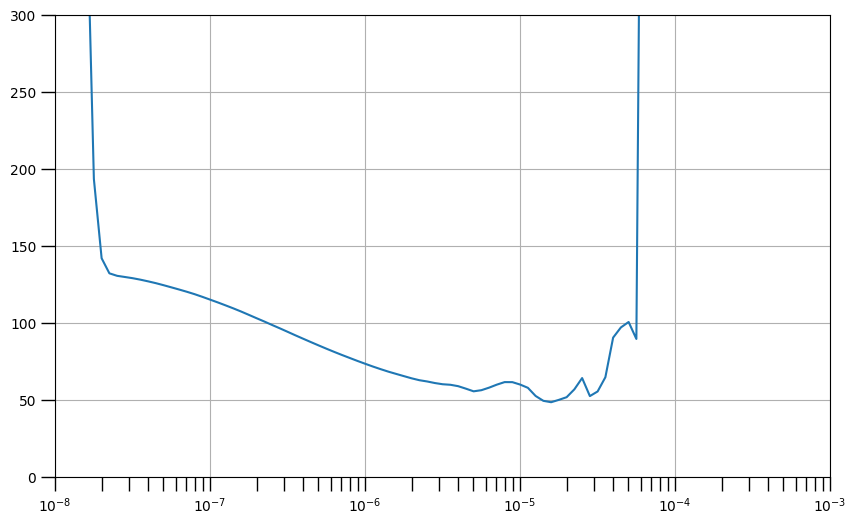

In [18]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 300])

The generated graph above shows the values of the range of learning rates that leads to lower losses (i.e. sloping downward) and also which ones cause the training to become unstable (i.e. jagged edges and pointing upwards). In general, you will want to pick a point in a downward slope. That means the network is still learning at that point and is stable. Choosing close to the minimum point of the graph will make the training converge to that loss value quicker, as will be shown in the next cells.

First, you will initialize the same model architecture again.

In [19]:
# Build the model
model_tune = tf.keras.models.Sequential([
    tf.keras.Input(shape=(window_size,)),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

You will then set the optimizer with a learning rate close to the minimum. It is set to `4e-6` initially but feel free to change based on your results.

In [20]:
# Set the optimizer with the tuned learning rate
optimizer = tf.keras.optimizers.SGD(learning_rate=4e-6, momentum=0.9)

You can then compile and train the model as before. Observe the loss values and compare it to the output of the baseline model you had before. Most likely, you will have met the final loss value of the `model_baseline` within the first 50 epochs of training this `model_tune`. You will also likely have a lower loss after all 100 epochs are done.

In [21]:
# Set the training parameters
model_tune.compile(loss="mse", optimizer=optimizer)

# Train the model
history = model_tune.fit(dataset, epochs=100)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 431.1075
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - loss: 73.6745
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step - loss: 66.5667
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - loss: 62.8572
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 60.5528
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step - loss: 58.5635
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 56.9711
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step - loss: 55.6290
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step - loss: 54.4506
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step - loss: 53.4298
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step - loss: 52.5558
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 51.6402
Epoch 13/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step - loss: 50.8911
Epoch 14/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 383us/step - loss: 50.1878
Epoch 15/100
31/31 ━━━━━━━━━━━

2024-10-03 11:34:57.857273: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:34:57.857312: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:34:57.873640: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:34:57.873672: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:34:57.886704: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:34:57.886721: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:34:57.901209: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv ite

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 48.3260
Epoch 18/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 47.8442
Epoch 19/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step - loss: 47.3232
Epoch 20/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 46.8590
Epoch 21/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - loss: 46.4429
Epoch 22/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step - loss: 46.0245
Epoch 23/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 45.6441
Epoch 24/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step - loss: 45.3546
Epoch 25/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step - loss: 45.0611
Epoch 26/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - loss: 44.7884
Epoch 27/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step - loss: 44.5378
Epoch 28/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - loss: 44.3237
Epoch 29/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - loss: 44.0845
Epoch 30/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 43.8874
Epoch 31/100
31/31 ━━━━━━━━━━━━━━

2024-10-03 11:34:58.069237: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:34:58.069258: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:34:58.083579: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:34:58.083604: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:34:58.097955: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:34:58.097974: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:34:58.111162: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv ite

Epoch 33/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - loss: 43.3164
Epoch 34/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step - loss: 43.1363
Epoch 35/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step - loss: 42.9540
Epoch 36/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 42.8588
Epoch 37/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step - loss: 42.7105
Epoch 38/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step - loss: 42.5812
Epoch 39/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - loss: 42.4455
Epoch 40/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step - loss: 42.3334
Epoch 41/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 42.2111
Epoch 42/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step - loss: 42.0890
Epoch 43/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 26.1098

2024-10-03 11:34:58.283752: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:34:58.283767: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:34:58.296373: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:34:58.296392: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:34:58.311153: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:34:58.311170: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:34:58.347697: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv ite

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 41.9976
Epoch 44/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step - loss: 41.8674
Epoch 45/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 41.7745
Epoch 46/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step - loss: 41.7058
Epoch 47/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 41.5830
Epoch 48/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - loss: 41.5237
Epoch 49/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 41.4195
Epoch 50/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 41.3529
Epoch 51/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 41.2722
Epoch 52/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - loss: 41.2071
Epoch 53/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - loss: 41.1333
Epoch 54/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 41.0648
Epoch 55/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step - loss: 40.9600
Epoch 56/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 40.9287
Epoch 57/100
 1/31 ━━━━━━━━━━━━━━━━

2024-10-03 11:34:58.508087: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:34:58.508107: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:34:58.528031: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:34:58.528052: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:34:58.544896: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:34:58.544911: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:34:58.558878: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv ite

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 40.8890
Epoch 58/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 40.8068
Epoch 59/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - loss: 40.7460
Epoch 60/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step - loss: 40.6799
Epoch 61/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step - loss: 40.6454
Epoch 62/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 40.5760
Epoch 63/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 367us/step - loss: 40.5221
Epoch 64/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step - loss: 40.4553
Epoch 65/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 40.4136
Epoch 66/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 26.0018

2024-10-03 11:34:58.713538: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:34:58.713560: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:34:58.729647: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:34:58.729663: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:34:58.743896: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:34:58.743918: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:34:58.759647: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv ite

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 40.3300
Epoch 67/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 40.2795
Epoch 68/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 40.2164
Epoch 69/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step - loss: 40.1595
Epoch 70/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 40.1147
Epoch 71/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step - loss: 40.0233
Epoch 72/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step - loss: 39.9766
Epoch 73/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 39.9131
Epoch 74/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step - loss: 39.8587
Epoch 75/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - loss: 39.8058
Epoch 76/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25.9367

2024-10-03 11:34:58.920011: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:34:58.920042: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:34:58.969300: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:34:58.969358: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:34:59.016155: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:34:59.016166: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:34:59.028528: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv ite

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - loss: 39.7752
Epoch 77/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step - loss: 39.7012
Epoch 78/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 39.6607
Epoch 79/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 39.6554
Epoch 80/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 39.6312
Epoch 81/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 25.9895

2024-10-03 11:34:59.129397: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:34:59.129418: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:34:59.144250: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:34:59.144272: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:34:59.179689: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:34:59.179720: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:34:59.240465: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv ite

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 39.5624
Epoch 82/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 39.5208
Epoch 83/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - loss: 39.4985
Epoch 84/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step - loss: 39.5031
Epoch 85/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step - loss: 39.3889
Epoch 86/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 39.3673
Epoch 87/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step - loss: 39.3560
Epoch 88/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - loss: 39.3291
Epoch 89/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 39.2571
Epoch 90/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - loss: 39.2431
Epoch 91/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 26.1042

2024-10-03 11:34:59.361577: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:34:59.427316: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:34:59.427326: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:34:59.440102: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:34:59.440109: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:34:59.452570: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:34:59.452576: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv ite

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 39.2336
Epoch 92/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 39.2002
Epoch 93/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 39.1702
Epoch 94/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - loss: 39.1056
Epoch 95/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step - loss: 39.0905
Epoch 96/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - loss: 39.0662
Epoch 97/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 39.0404
Epoch 98/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - loss: 39.0372
Epoch 99/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step - loss: 38.9761
Epoch 100/100
 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 26.3201

2024-10-03 11:34:59.620775: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:34:59.620803: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:34:59.665903: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:34:59.697599: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:34:59.722782: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:34:59.722802: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622
2024-10-03 11:34:59.752631: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - loss: 39.0336


2024-10-03 11:34:59.825922: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 710597020391181761
2024-10-03 11:34:59.825944: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 12882780226983556622


You can plot the `loss` values by getting it from the [History](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History) object returned by the `fit()` method. As you can see, the model is still trending downward after the training.

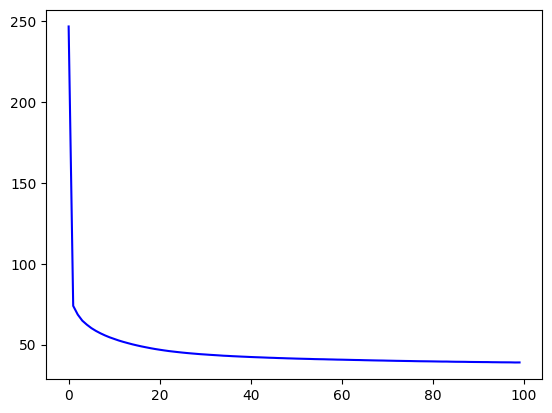

In [22]:
# Plot the loss
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

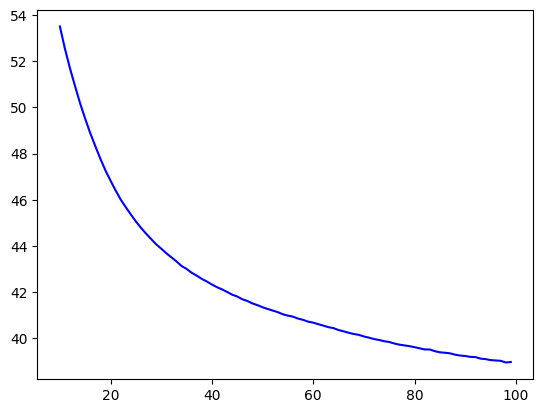

In [23]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

You can get the predictions again and overlay it on the validation set.

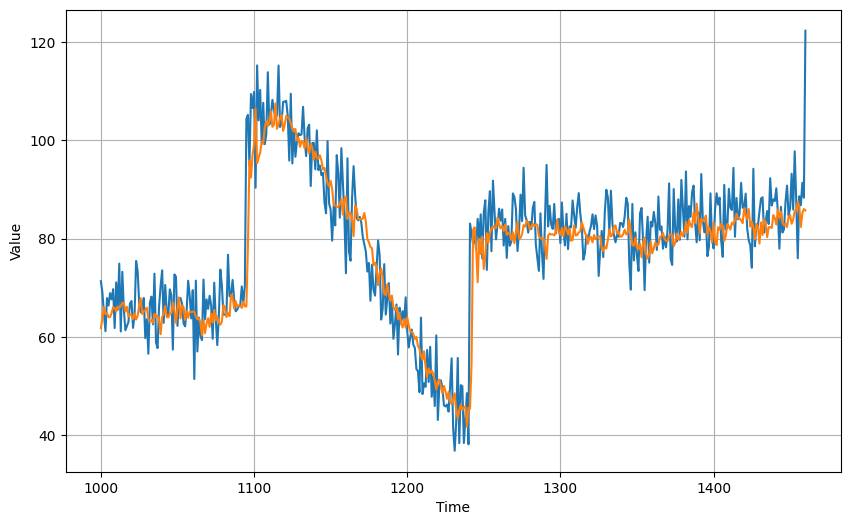

In [24]:
# Initialize a list
forecast = []

# Reduce the original series
forecast_series = series[split_time - window_size:]

# Use the model to predict data points per window size
for time in range(len(forecast_series) - window_size):
  forecast.append(model_tune.predict(forecast_series[time:time + window_size][np.newaxis], verbose=0))

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

Finally, you can compute the metrics and you should arrive at similar figures compared to the baseline. If it is much worse, then the model might have overfitted and you can use techniques you know to avoid it (e.g. adding dropout).

In [25]:
print(tf.keras.metrics.mse(x_valid, results).numpy())
print(tf.keras.metrics.mae(x_valid, results).numpy())

45.598724
4.872778


## Wrap Up

This concludes the exercise on using a deep neural network for forecasting. Along the way, you did some hyperparameter tuning, particularly on the learning rate. You will be using this technique as well in the next labs. Next week, you will be using recurrent neural networks to build your forecasting model. See you there and keep it up!